In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eigvals
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load California Housing Dataset (modern replacement for Boston Housing)
data = fetch_california_housing()
X, y = data.data, data.target.reshape(-1, 1)

# Add intercept term (bias)
X = np.hstack([np.ones((X.shape[0], 1)), X])  # shape: (n_samples, n_features + 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (excluding intercept)
scaler = StandardScaler()
X_train[:, 1:] = scaler.fit_transform(X_train[:, 1:])
X_test[:, 1:] = scaler.transform(X_test[:, 1:])

# Compute Hessian
n_train = X_train.shape[0]
Hessian = (1 / n_train) * (X_train.T @ X_train)
eigenvalues = eigvals(Hessian)

# Determine convexity
if np.all(eigenvalues > 0):
    convexity = "🟢 Positive Definite → Strictly Convex"
elif np.all(eigenvalues >= 0) and np.any(eigenvalues == 0):
    convexity = "🟡 Positive Semi-Definite → Convex (Flat directions)"
elif np.any(eigenvalues > 0) and np.any(eigenvalues < 0):
    convexity = "⚠️ Indefinite → Non-convex or Saddle Points"
else:
    convexity = "❓ Could not classify"

# Train a Linear Regression model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

Hessian, eigenvalues, convexity, mse


(array([[ 1.00000000e+00, -6.59205679e-15, -4.67971914e-18,
          7.98693583e-15, -1.19854600e-15, -5.05624827e-18,
         -1.07445276e-16,  7.98698424e-14, -3.87935041e-13],
        [-6.59205679e-15,  1.00000000e+00, -1.21711069e-01,
          3.36012863e-01, -7.25495867e-02,  4.12244117e-03,
          2.20611204e-02, -7.65711343e-02, -1.70397462e-02],
        [-4.67971914e-18, -1.21711069e-01,  1.00000000e+00,
         -1.60891609e-01, -8.79826412e-02, -2.92283114e-01,
          1.62452854e-02,  5.29569256e-03, -1.01817869e-01],
        [ 7.98693583e-15,  3.36012863e-01, -1.60891609e-01,
          1.00000000e+00,  8.36162859e-01, -7.37328153e-02,
         -4.92165010e-03,  1.10694803e-01, -2.93386718e-02],
        [-1.19854600e-15, -7.25495867e-02, -8.79826412e-02,
          8.36162859e-01,  1.00000000e+00, -7.12668016e-02,
         -6.03488296e-03,  7.31608106e-02,  1.66466751e-02],
        [-5.05624827e-18,  4.12244117e-03, -2.92283114e-01,
         -7.37328153e-02, -7.126680

In [ ]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# 🧱 Base class with shared methods
class BaseLinearRegression:
    def __init__(self, alpha=0.01, epochs=1000):
        self.alpha = alpha
        self.epochs = epochs
        self.theta = None
        self.cost_history = []

    def hypothesis(self, X):
        return X @ self.theta

    def compute_cost(self, X, y):
        m = len(y)
        predictions = self.hypothesis(X)
        errors = predictions - y
        return (1 / (2 * m)) * np.sum(errors ** 2)

    def predict(self, X):
        return self.hypothesis(X)

    def plot_cost(self):
        plt.plot(range(len(self.cost_history)), self.cost_history)
        plt.xlabel("Epochs")
        plt.ylabel("Cost")
        plt.title("Cost over Epochs")
        plt.grid()
        plt.show()


# 📦 1. Batch Gradient Descent
class BatchGDRegressor(BaseLinearRegression):
    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)
        for _ in range(self.epochs):
            predictions = self.hypothesis(X)
            gradient = (1 / m) * (X.T @ (predictions - y))
            self.theta -= self.alpha * gradient
            self.cost_history.append(self.compute_cost(X, y))


# 🧩 2. Mini-Batch Gradient Descent
class MiniBatchGDRegressor(BaseLinearRegression):
    def __init__(self, alpha=0.01, epochs=1000, batch_size=32):
        super().__init__(alpha, epochs)
        self.batch_size = batch_size

    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)  # shape: (n,)
        y = y.flatten()  # Ensure shape: (m,)

        for epoch in range(self.epochs):
            X_shuffled, y_shuffled = shuffle(X, y)
            for i in range(0, m, self.batch_size):
                end = i + self.batch_size
                X_batch = X_shuffled[i:end]
                y_batch = y_shuffled[i:end]

                predictions = X_batch @ self.theta  # shape: (batch_size,)
                errors = predictions - y_batch      # shape: (batch_size,)
                gradient = (1 / len(X_batch)) * (X_batch.T @ errors)  # shape: (n,)
                self.theta -= self.alpha * gradient

            self.cost_history.append(self.compute_cost(X, y.reshape(-1, 1)))



# 🔁 3. Stochastic Gradient Descent (SGD)
class SGDRegressor(BaseLinearRegression):
    def fit(self, X, y):
        m, n = X.shape
        self.theta = np.zeros(n)
        for epoch in range(self.epochs):
            X_shuffled, y_shuffled = shuffle(X, y)
            for i in range(m):
                xi = X_shuffled[i].reshape(1, -1)   # (1, n)
                yi = y_shuffled[i]
                prediction = self.hypothesis(xi)
                gradient = (prediction - yi) * xi
                self.theta -= self.alpha * gradient.flatten()
            self.cost_history.append(self.compute_cost(X, y))


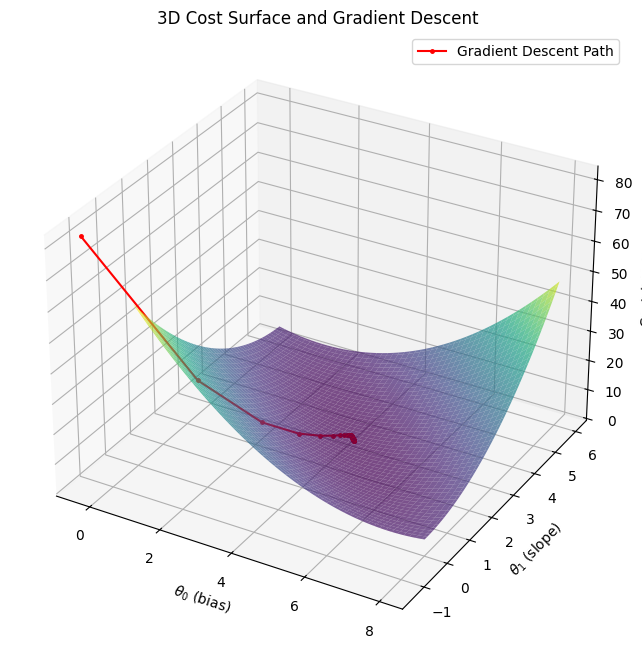

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Generate synthetic data
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Add intercept term (bias)
X_b = np.c_[np.ones((100, 1)), X]

# 2. Create cost function
def compute_mse(theta):
    predictions = X_b @ theta
    error = predictions - y
    return (1 / len(y)) * np.sum(error ** 2)

# 3. Generate meshgrid for θ0 and θ1
theta0_vals = np.linspace(0, 8, 100)
theta1_vals = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

# 4. Compute cost surface (MSE)
J_vals = np.array([[compute_mse(np.array([[t0], [t1]])) for t0 in theta0_vals] for t1 in theta1_vals])

# 5. Run Gradient Descent and store path
def gradient_descent_path(X_b, y, learning_rate=0.1, n_iters=50):
    m = len(y)
    theta = np.random.randn(2, 1)  # Random init
    path = [theta.copy()]
    
    for _ in range(n_iters):
        gradients = 2/m * X_b.T @ (X_b @ theta - y)
        theta -= learning_rate * gradients
        path.append(theta.copy())
        
    return theta, path

theta_final, path = gradient_descent_path(X_b, y)

# Extract path for plotting
theta0_path = [theta[0, 0] for theta in path]
theta1_path = [theta[1, 0] for theta in path]
cost_path = [compute_mse(np.array([[t0], [t1]])) for t0, t1 in zip(theta0_path, theta1_path)]

# 6. 3D Plot using plot_surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the cost surface
ax.plot_surface(T0, T1, J_vals, cmap='viridis', alpha=0.7)

# Plot the gradient descent path
ax.plot(theta0_path, theta1_path, cost_path, 'r.-', markersize=5, label='Gradient Descent Path')

ax.set_xlabel(r'$\theta_0$ (bias)')
ax.set_ylabel(r'$\theta_1$ (slope)')
ax.set_zlabel('Cost (MSE)')
ax.set_title('3D Cost Surface and Gradient Descent')
ax.legend()
plt.show()


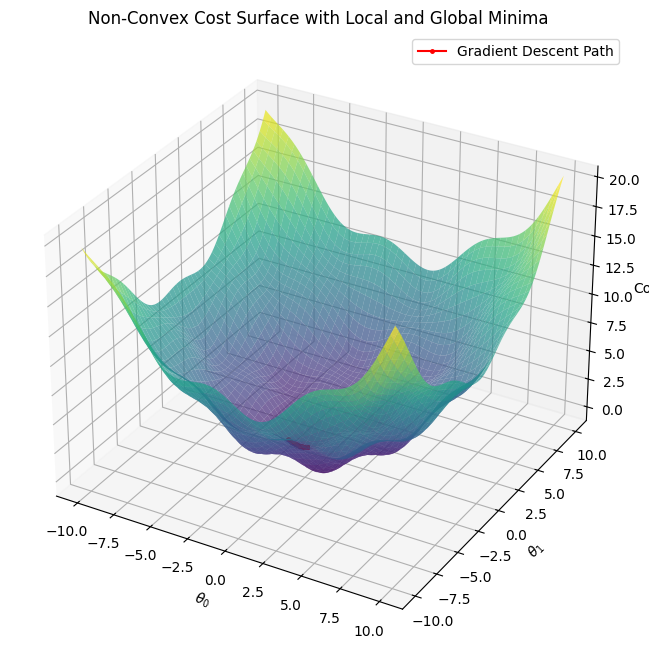

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Create a synthetic non-convex cost function with multiple local minima
def complex_cost_function(theta):
    t0, t1 = theta[0], theta[1]
    return np.sin(t0) * np.cos(t1) + 0.1 * (t0**2 + t1**2)

# 2. Generate a meshgrid for θ0 and θ1
theta0_vals = np.linspace(-10, 10, 200)
theta1_vals = np.linspace(-10, 10, 200)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

# 3. Compute the complex cost surface
J_vals = np.array([[complex_cost_function([t0, t1]) for t0 in theta0_vals] for t1 in theta1_vals])

# 4. Simulate a gradient descent path on the non-convex surface
def gradient_descent_complex(cost_func, grad_func, lr=0.1, n_iters=50):
    theta = np.random.uniform(-9, 9, size=2)
    path = [theta.copy()]
    for _ in range(n_iters):
        grad = grad_func(theta)
        theta = theta - lr * grad
        path.append(theta.copy())
    return np.array(path)

# 5. Define the gradient of the cost function
def complex_gradient(theta):
    t0, t1 = theta[0], theta[1]
    dt0 = np.cos(t0) * np.cos(t1) + 0.2 * t0
    dt1 = -np.sin(t0) * np.sin(t1) + 0.2 * t1
    return np.array([dt0, dt1])

# 6. Run gradient descent
path = gradient_descent_complex(complex_cost_function, complex_gradient)

# Extract path for plotting
theta0_path = path[:, 0]
theta1_path = path[:, 1]
cost_path = [complex_cost_function([t0, t1]) for t0, t1 in zip(theta0_path, theta1_path)]

# 7. 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the cost surface
ax.plot_surface(T0, T1, J_vals, cmap='viridis', alpha=0.7)

# Plot the gradient descent path
ax.plot(theta0_path, theta1_path, cost_path, 'r.-', markersize=5, label='Gradient Descent Path')

ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel('Cost')
ax.set_title('Non-Convex Cost Surface with Local and Global Minima')
ax.legend()
plt.show()


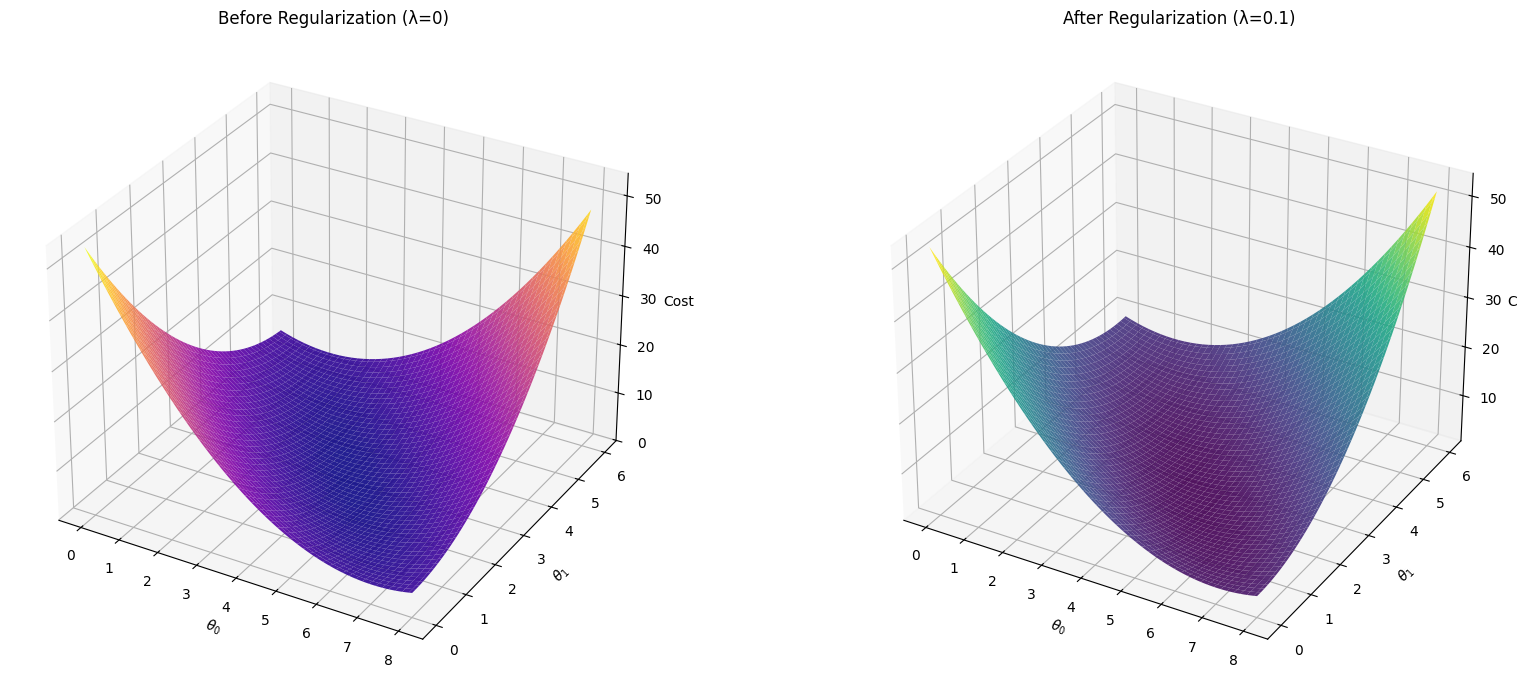

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Generate synthetic data
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Add intercept term
X_b = np.c_[np.ones((100, 1)), X]

# 2. Compute cost (with optional L2 regularization)
def compute_cost(theta, X_b, y, lam=0):
    predictions = X_b @ theta
    error = predictions - y
    cost = (1 / len(y)) * np.sum(error ** 2)
    reg_term = lam * np.sum(theta[1:] ** 2)
    return cost + reg_term

# 3. Create meshgrid for plotting
theta0_vals = np.linspace(0, 8, 100)
theta1_vals = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

# 4. Compute cost surface
J_vals_before = np.array([[compute_cost(np.array([[t0], [t1]]), X_b, y) for t0 in theta0_vals] for t1 in theta1_vals])
J_vals_after = np.array([[compute_cost(np.array([[t0], [t1]]), X_b, y, lam=0.1) for t0 in theta0_vals] for t1 in theta1_vals])

# 5. Plot both 3D surfaces
fig = plt.figure(figsize=(18, 7))

# Before optimization
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T0, T1, J_vals_before, cmap='plasma', alpha=0.9)
ax1.set_title('Before Regularization (λ=0)')
ax1.set_xlabel(r'$\theta_0$')
ax1.set_ylabel(r'$\theta_1$')
ax1.set_zlabel('Cost')

# After regularization
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T0, T1, J_vals_after, cmap='viridis', alpha=0.9)
ax2.set_title('After Regularization (λ=0.1)')
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel(r'$\theta_1$')
ax2.set_zlabel('Cost')

plt.tight_layout()
plt.show()


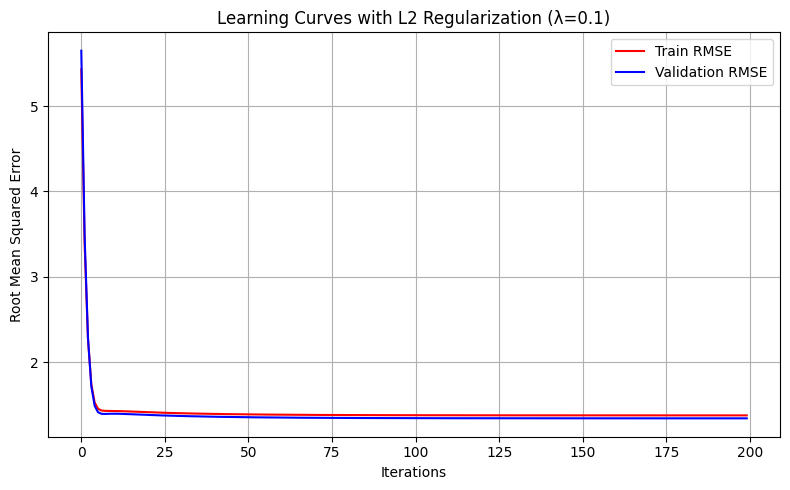

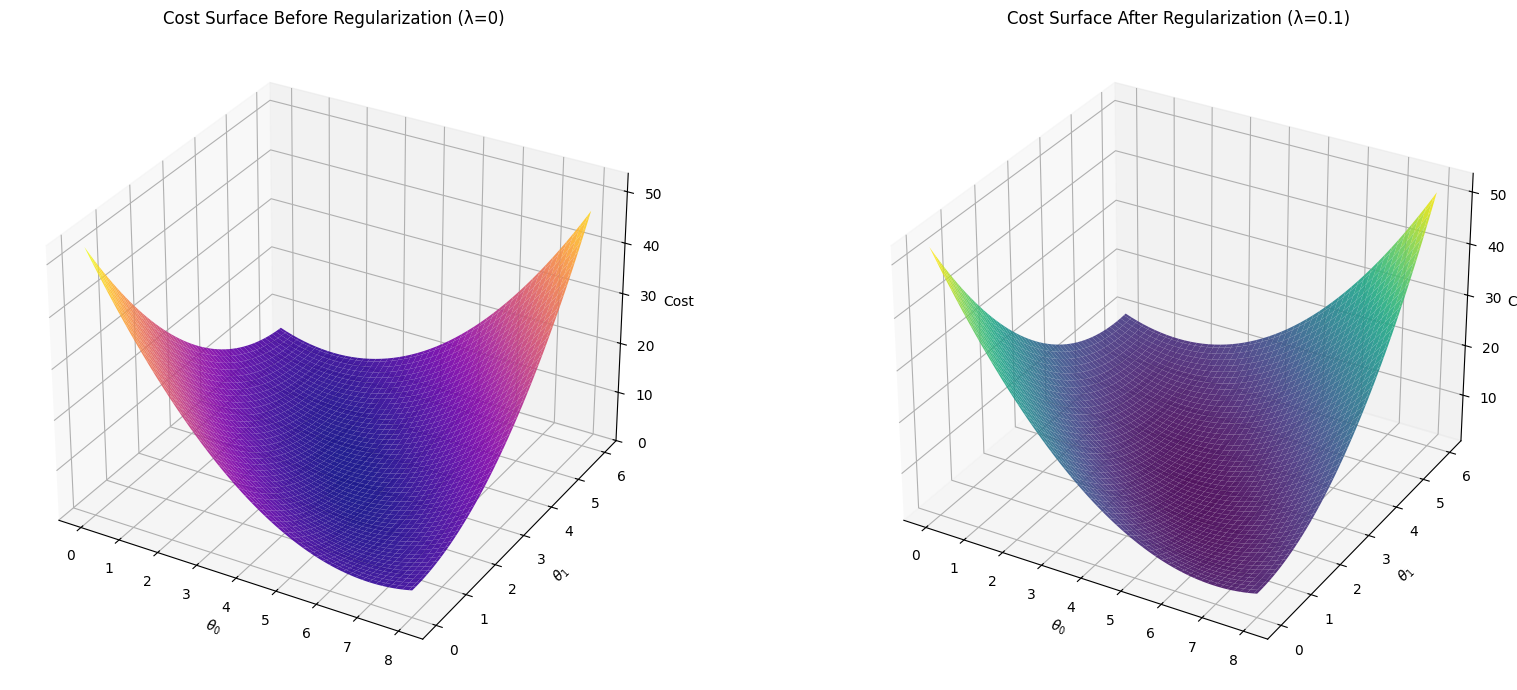

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 1. Generate synthetic data
np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Add intercept term
X_b = np.c_[np.ones((100, 1)), X]

# 2. Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(X_b, y, test_size=0.2, random_state=42)

# 3. Compute cost with L2 regularization
def compute_cost(theta, X_b, y, lam=0.0):
    m = len(y)
    predictions = X_b @ theta
    error = predictions - y
    cost = (1 / m) * np.sum(error ** 2)
    reg_term = lam * np.sum(theta[1:] ** 2)
    return cost + reg_term

# 4. Gradient Descent with L2 Regularization
def gradient_descent(X_b, y, alpha=0.1, n_iter=200, lam=0.0):
    m = len(y)
    theta = np.random.randn(X_b.shape[1], 1)
    train_costs, val_costs = [], []

    for _ in range(n_iter):
        gradients = (2/m) * (X_b.T @ (X_b @ theta - y) + lam * np.r_[[[0]], theta[1:]])
        theta -= alpha * gradients

        train_costs.append(compute_cost(theta, X_train, y_train, lam))
        val_costs.append(compute_cost(theta, X_val, y_val, lam))
    
    return theta, train_costs, val_costs

# 5. Cost surface meshgrid
theta0_vals = np.linspace(0, 8, 100)
theta1_vals = np.linspace(0, 6, 100)
T0, T1 = np.meshgrid(theta0_vals, theta1_vals)

J_vals_before = np.array([[compute_cost(np.array([[t0], [t1]]), X_train, y_train) for t0 in theta0_vals] for t1 in theta1_vals])
J_vals_after = np.array([[compute_cost(np.array([[t0], [t1]]), X_train, y_train, lam=0.1) for t0 in theta0_vals] for t1 in theta1_vals])

# 6. Run optimization
theta_final, train_losses, val_losses = gradient_descent(X_train, y_train, alpha=0.1, n_iter=200, lam=0.1)

# 7. Plot Train and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(np.sqrt(train_losses), 'r-', label="Train RMSE")
plt.plot(np.sqrt(val_losses), 'b-', label="Validation RMSE")
plt.xlabel("Iterations")
plt.ylabel("Root Mean Squared Error")
plt.title("Learning Curves with L2 Regularization (λ=0.1)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 8. Plot 3D surfaces before and after
fig = plt.figure(figsize=(18, 7))

# Before Regularization
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T0, T1, J_vals_before, cmap='plasma', alpha=0.9)
ax1.set_title('Cost Surface Before Regularization (λ=0)')
ax1.set_xlabel(r'$\theta_0$')
ax1.set_ylabel(r'$\theta_1$')
ax1.set_zlabel('Cost')

# After Regularization
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(T0, T1, J_vals_after, cmap='viridis', alpha=0.9)
ax2.set_title('Cost Surface After Regularization (λ=0.1)')
ax2.set_xlabel(r'$\theta_0$')
ax2.set_ylabel(r'$\theta_1$')
ax2.set_zlabel('Cost')

plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0

        self.head_dim = embed_dim // num_heads
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, T, C = x.size()
        q = self.query(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        attn_scores = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_scores = attn_scores.masked_fill(torch.tril(torch.ones(T, T)) == 0, float('-inf'))
        attn_weights = F.softmax(attn_scores, dim=-1)

        attn_output = attn_weights @ v
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)
        return self.out(attn_output)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden):
        super().__init__()
        self.attn = SelfAttention(embed_dim, num_heads)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, embed_dim)
        )
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, vocab_size, max_len, embed_dim, num_heads, ff_hidden, num_layers):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(max_len, embed_dim)
        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, ff_hidden) for _ in range(num_layers)
        ])
        self.ln_final = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)

    def forward(self, idx):
        B, T = idx.shape
        tok_emb = self.token_embed(idx)
        pos = torch.arange(T, device=idx.device).unsqueeze(0)
        pos_emb = self.pos_embed(pos)
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_final(x)
        return self.head(x)


In [2]:
# Configuration
vocab_size = 100   # pretend we have 100 tokens
max_len = 32
embed_dim = 64
num_heads = 4
ff_hidden = 256
num_layers = 2

# Initialize model
model = GPT(vocab_size, max_len, embed_dim, num_heads, ff_hidden, num_layers)

# Dummy input (batch_size=2, sequence_len=32)
x = torch.randint(0, vocab_size, (2, 32))
out = model(x)

print(out.shape)  # Expected: [2, 32, vocab_size]


torch.Size([2, 32, 100])


In [3]:
!pip install transformers


  Using cached transformers-4.54.1-py3-none-any.whl.metadata (41 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.4-cp39-abi3-macosx_11_0_arm64.whl.metadata (6.7 kB)
  Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl.metadata (3.8 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-macosx_11_0_arm64.whl.metadata (879 bytes)
Using cached transformers-4.54.1-py3-none-any.whl (11.2 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
Using cached hf_xet-1.1.5-cp37-abi3-macosx_11_0_arm64.whl (2.6 MB)
Using cached tokenizers-0.21.4-cp39-abi3-macosx_11_0_arm64.whl (2.7 MB)
Using cached safetensors-0.5.3-cp38-abi3-macosx_11_0_arm64.whl (418 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [transformers] [transformers]ub]


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch


/opt/anaconda3/envs/mlops-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install pytesseract

In [8]:
import pytesseract
from PIL import Image

# Load image
image = Image.open("/Users/anand/Desktop/Ml_deep_notes_for_myself/Images/Screenshot 2025-08-03 at 10.35.15.png")

# Extract text
raw_text = pytesseract.image_to_string(image)
print(raw_text)


Zp Stochastic grack

ient ol
Zp Momentum F il seat 6
Zp RMSprop \~

Z> Aclam opti
ptimizer uh

